<a href="https://colab.research.google.com/github/pranjal299/cv-project/blob/main/Smart_Pigs_Data_DL_Features_Stan_Starter_6_Classes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Mount Google Drive 
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


### Training Code

In [2]:
!nvidia-smi

Fri Dec 30 03:58:39 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P0    27W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!gdown "1--iUzzvmYpINyr0zkB69xI4P9ZABM2A9&confirm=t"
!gdown "1-17BDu_8mGJdvDQ8aUxDWjm0UpUaQJ-e&confirm=t"
!gdown "1-28nY4MxnpajMwKJgNDv596NfaML1TfU&confirm=t" 
!gdown "1c3gl74SgqYeUZH0ExiucL1w0xeFvcyDU&confirm=t"

Downloading...
From: https://drive.google.com/uc?id=1--iUzzvmYpINyr0zkB69xI4P9ZABM2A9&confirm=t
To: /content/X_test_pigs_combined_win_128_64_clean.csv
100% 387M/387M [00:02<00:00, 133MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-17BDu_8mGJdvDQ8aUxDWjm0UpUaQJ-e&confirm=t
To: /content/Y_train_pigs_win_128_64_clean.csv
100% 1.48M/1.48M [00:00<00:00, 177MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-28nY4MxnpajMwKJgNDv596NfaML1TfU&confirm=t
To: /content/Y_test_pigs_win_128_64_clean.csv
100% 492k/492k [00:00<00:00, 131MB/s]
Downloading...
From: https://drive.google.com/uc?id=1c3gl74SgqYeUZH0ExiucL1w0xeFvcyDU&confirm=t
To: /content/X_train_pigs_combined_win_128_64_clean.csv
100% 1.16G/1.16G [00:08<00:00, 136MB/s]


In [3]:
# cnn model
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from keras.utils import plot_model
import tensorflow as tf
from PIL import Image
from google.colab.patches import cv2_imshow
import cv2
from keras.models import load_model
import keras

In [4]:
def evaluate_model(trainX, trainy, testX, testy, epochs, batch_size, r):
  verbose, epochs, batch_size = 1, epochs, batch_size
  model = create_model(trainX, trainy)
  callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model_epochs_"+str(epochs)+"_batch_size_"+str(batch_size)+"_iteration_"+str(r)+".h5", save_best_only=True, monitor="val_accuracy", verbose = 1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_accuracy", factor=0.5, patience=20, min_lr=0.0001, verbose = 1
    ),
    keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=50, verbose=1),
  ]
  history = model.fit(trainX, trainy, validation_data = (testX,testy), epochs=epochs, batch_size=batch_size, verbose=verbose,callbacks=callbacks,)
  # list all data in history
  print(history.history.keys())
  # summarize history for accuracy
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  # evaluate model
  model = load_model("best_model_epochs_"+str(epochs)+"_batch_size_"+str(batch_size)+"_iteration_"+str(r)+".h5")
  _, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
  return accuracy

In [5]:
def create_model(trainX, trainy):
  n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
  model = Sequential()
  model.add(Conv1D(48, 3, activation='relu', input_shape=(n_timesteps,n_features)))
  model.add(Dropout(0.5))
  model.add(Conv1D(48, 3, activation='relu'))
  model.add(Dropout(0.5))
  model.add(MaxPooling1D())
  model.add(Flatten())
  model.add(Dense(100, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(n_outputs, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  # visualize model
  model_plot(model)
  return model

In [6]:
def model_plot(model):
  tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
  img = cv2.imread('model.png')
  cv2_imshow(img)
  return model

In [8]:
# summarize scores
def summarize_results(scores):
  print(scores)
  m = max(scores)
  print('Best Accuracy: ',m,'%')

In [9]:
# run an experiment
def run_experiment(repeats,epochs,batch_size,X_train_i,y_train,X_test_i,y_test):
  # load data
  #trainX, trainy, testX, testy = load_dataset()
  trainX = X_train_i
  trainy = y_train
  testX = X_test_i
  testy = y_test
  # repeat experiment
  scores = list()
  for r in range(repeats):
    score = evaluate_model(trainX, trainy, testX, testy, epochs, batch_size, r)
    score = score * 100.0
    print('>#%d: %.3f' % (r+1, score))
    scores.append(score)
  # summarize results
  summarize_results(scores)

### Input Data Code

In [10]:
import numpy as np
import pandas as pd
np.set_printoptions(suppress=True)

In [11]:
X_train = np.genfromtxt('/content/gdrive/MyDrive/ready2use/windowed_YP/X_train_pigs_win_128_64_time_features.csv', delimiter=',')
X_test = np.genfromtxt('/content/gdrive/MyDrive/ready2use/windowed_YP/X_test_pigs_win_128_64_time_features.csv', delimiter=',')
y_train = np.genfromtxt('/content/gdrive/MyDrive/ready2use/windowed_YP/y_train_pigs_win_128_64_strings.csv', delimiter=',',dtype=str)
y_test = np.genfromtxt('/content/gdrive/MyDrive/ready2use/windowed_YP/y_test_pigs_win_128_64_strings.csv', delimiter=',',dtype=str)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(59053, 36)
(19683, 36)
(59053,)
(19683,)


In [12]:
X_train= X_train[(y_train=='Eating') | (y_train=='Laying') | (y_train=='Standing') | (y_train=='Walking') | (y_train=='Drinking') | (y_train=='Interacting With Each Other')]
X_test= X_test[(y_test=='Eating') | (y_test=='Laying') | (y_test=='Standing') | (y_test=='Walking') | (y_test=='Drinking') | (y_test=='Interacting With Each Other')]

In [13]:
y_train = y_train[(y_train=='Eating') | (y_train=='Laying') | (y_train=='Standing') | (y_train=='Walking') | (y_train=='Drinking') | (y_train=='Interacting With Each Other')]
y_test = y_test[(y_test=='Eating') | (y_test=='Laying') | (y_test=='Standing') | (y_test=='Walking') | (y_test=='Drinking') | (y_test=='Interacting With Each Other')]

In [ ]:
y_train = y_train[(y_train=='Eating') | (y_train=='Laying') | (y_train=='Standing') | (y_train=='Walking') | (y_train=='Drinking') | (y_train=='Interacting With Each Other')]
y_test = y_test[(y_test=='Eating') | (y_test=='Laying') | (y_test=='Standing') | (y_test=='Walking') | (y_test=='Drinking') | (y_test=='Interacting With Each Other')]

In [14]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(55657, 36)
(18382, 36)
(55657,)
(18382,)


In [15]:
y_train = np.char.replace(y_train, 'Standing','0')
y_train = np.char.replace(y_train, 'Walking','1')
y_train = np.char.replace(y_train, 'Eating','2')
y_train = np.char.replace(y_train, 'Interacting With Each Other','3')
y_train = np.char.replace(y_train, 'Laying','4')
y_train = np.char.replace(y_train, 'Drinking','5')

In [16]:
y_test = np.char.replace(y_test, 'Standing','0')
y_test = np.char.replace(y_test, 'Walking','1')
y_test = np.char.replace(y_test, 'Eating','2')
y_test = np.char.replace(y_test, 'Interacting With Each Other','3')
y_test = np.char.replace(y_test, 'Laying','4')
y_test = np.char.replace(y_test, 'Drinking','5')

In [17]:
y_train=y_train.astype(int)
y_test=y_test.astype(int)

Copy till above cell for decreasing classes

In [18]:
y_train = y_train.reshape((len(y_train),1))
y_test = y_test.reshape((len(y_test),1))

In [19]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [24]:
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)

In [22]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(55657, 36)
(18382, 36)
(55657, 6)
(18382, 6)


### Experiment Code

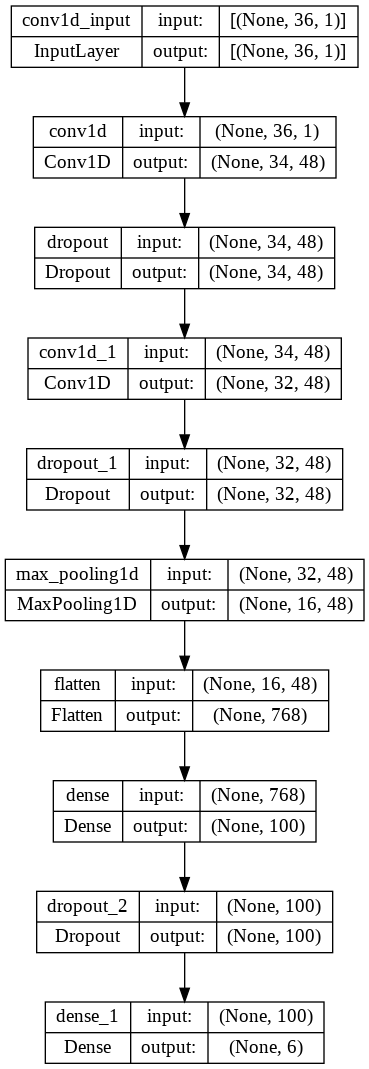

Epoch 1/1000
435/435 [==============================] - ETA: 0s - loss: 0.6431 - accuracy: 0.8027
Epoch 1: val_accuracy improved from -inf to 0.85051, saving model to best_model_epochs_1000_batch_size_128_iteration_0.h5
435/435 [==============================] - 11s 6ms/step - loss: 0.6431 - accuracy: 0.8027 - val_loss: 0.4550 - val_accuracy: 0.8505 - lr: 0.0010
Epoch 2/1000
428/435 [============================>.] - ETA: 0s - loss: 0.4551 - accuracy: 0.8599
Epoch 2: val_accuracy improved from 0.85051 to 0.87586, saving model to best_model_epochs_1000_batch_size_128_iteration_0.h5
435/435 [==============================] - 2s 5ms/step - loss: 0.4550 - accuracy: 0.8599 - val_loss: 0.3752 - val_accuracy: 0.8759 - lr: 0.0010
Epoch 3/1000
428/435 [============================>.] - ETA: 0s - loss: 0.4108 - accuracy: 0.8755
Epoch 3: val_accuracy improved from 0.87586 to 0.88668, saving model to best_model_epochs_1000_batch_size_128_iteration_0.h5
435/435 [==============================] - 2s

In [ ]:
run_experiment(repeats = 5,epochs = 1000,batch_size = 128,X_train_i = X_train ,y_train = y_train, X_test_i = X_test, y_test = y_test) #1000 epochs